# Practice 11: Long Short Term Memory (LSTM)

Use this notebook as the starting point for the Practice activities.

Student Name:    **[  Put your Name Here ]**

The original version of the notebook from from the online course, Applications of Deep Neural Networks, Module 10: Recurrent and LSTM Networks
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), School of Engineering and Applied Science, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

# Module Video Material

Original video lecture by Jeff Heaton:

* [Part 10.1: Time Series Data Encoding](https://www.youtube.com/watch?v=X72l3HIt8ro&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN&index=29)
* [Part 10.2: Introduction to LSTM](https://www.youtube.com/watch?v=hRDfQGbqJJQ&index=30&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN)
* [Part 10.3: LSTM in Keras](https://www.youtube.com/watch?v=UnclHXZszpw&index=31&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN)


# Helpful Functions
## You do not need know how these work for our CIS 4115 Particpation activity

You will see these at the top of every module.  These are simply a set of reusable functions that we will make use of.  Each of them will be explained as the semester progresses.  They are explained in greater detail as the course progresses.  Class 4 contains a complete overview of these functions.

In [40]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import requests
import base64


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
        
# This function submits an assignment.  You can submit an assignment as much as you like, only the final
# submission counts.  The paramaters are as follows:
# data - Pandas dataframe output.
# key - Your student key that was emailed to you.
# no - The assignment class number, should be 1 through 1.
# source_file - The full path to your Python or IPYNB file.  This must have "_class1" as part of its name.  
# .             The number must match your assignment number.  For example "_class2" for class assignment #2.
def submit(data,key,no,source_file=None):
    if source_file is None and '__file__' not in globals(): raise Exception('Must specify a filename when a Jupyter notebook.')
    if source_file is None: source_file = __file__
    suffix = '_class{}'.format(no)
    if suffix not in source_file: raise Exception('{} must be part of the filename.'.format(suffix))
    with open(source_file, "rb") as image_file:
        encoded_python = base64.b64encode(image_file.read()).decode('ascii')
    ext = os.path.splitext(source_file)[-1].lower()
    if ext not in ['.ipynb','.py']: raise Exception("Source file is {} must be .py or .ipynb".format(ext))
    r = requests.post("https://api.heatonresearch.com/assignment-submit",
        headers={'x-api-key':key}, json={'csv':base64.b64encode(data.to_csv(index=False).encode('ascii')).decode("ascii"),
        'assignment': no, 'ext':ext, 'py':encoded_python})
    if r.status_code == 200:
        print("Success: {}".format(r.text))
    else: print("Failure: {}".format(r.text))
        
def to_sequences(seq_size, obs):
    x = []
    y = []

    for i in range(len(obs)-SEQUENCE_SIZE-1):
        #print(i)
        window = obs[i:(i+SEQUENCE_SIZE)]
        after_window = obs[i+SEQUENCE_SIZE]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)

# Data Structure for Recurrent Neural Networks
## You do not need this for our CIS 4115 Particpation activity

Previously we trained neural networks with input ($x$) and expected output ($y$).  $X$ was a matrix, the rows were training examples and the columns were values to be predicted.  The definition of $x$ will be expanded and y will stay the same.

Dimensions of training set ($x$):
* Axis 1: Training set elements (sequences) (must be of the same size as $y$ size)
* Axis 2: Members of sequence
* Axis 3: Features in data (like input neurons)

Previously, we might take as input a single stock price, to predict if we should buy (1), sell (-1), or hold (0).

In [2]:
# 

x = [
    [32],
    [41],
    [39],
    [20],
    [15]
]

y = [
    1,
    -1,
    0,
    -1,
    1
]

print(x)
print(y)

[[32], [41], [39], [20], [15]]
[1, -1, 0, -1, 1]


This is essentially building a CSV file from scratch, to see it as a data frame, use the following:

In [3]:
from IPython.display import display, HTML
import pandas as pd
import numpy as np

x = np.array(x)
print(x[:,0])


df = pd.DataFrame({'x':x[:,0], 'y':y})
display(df)

[32 41 39 20 15]


,x,y
0,32,1
1,41,-1
2,39,0
3,20,-1
4,15,1


You might want to put volume in with the stock price.  

In [4]:
x = [
    [32,1383],
    [41,2928],
    [39,8823],
    [20,1252],
    [15,1532]
]

y = [
    1,
    -1,
    0,
    -1,
    1
]

print(x)
print(y)

[[32, 1383], [41, 2928], [39, 8823], [20, 1252], [15, 1532]]
[1, -1, 0, -1, 1]


Again, very similar to what we did before.  The following shows this as a data frame.

In [5]:
from IPython.display import display, HTML
import pandas as pd
import numpy as np

x = np.array(x)
print(x[:,0])


df = pd.DataFrame({'price':x[:,0], 'volume':x[:,1], 'y':y})
display(df)

[32 41 39 20 15]


,price,volume,y
0,32,1383,1
1,41,2928,-1
2,39,8823,0
3,20,1252,-1
4,15,1532,1


Now we get to sequence format.  We want to predict something over a sequence, so the data format needs to add a dimension.  A maximum sequence length must be specified, but the individual sequences can be of any length.

In [6]:
x = [
    [[32,1383],[41,2928],[39,8823],[20,1252],[15,1532]],
    [[35,8272],[32,1383],[41,2928],[39,8823],[20,1252]],
    [[37,2738],[35,8272],[32,1383],[41,2928],[39,8823]],
    [[34,2845],[37,2738],[35,8272],[32,1383],[41,2928]],
    [[32,2345],[34,2845],[37,2738],[35,8272],[32,1383]],
]

y = [
    1,
    -1,
    0,
    -1,
    1
]

print(x)
print(y)

[[[32, 1383], [41, 2928], [39, 8823], [20, 1252], [15, 1532]], [[35, 8272], [32, 1383], [41, 2928], [39, 8823], [20, 1252]], [[37, 2738], [35, 8272], [32, 1383], [41, 2928], [39, 8823]], [[34, 2845], [37, 2738], [35, 8272], [32, 1383], [41, 2928]], [[32, 2345], [34, 2845], [37, 2738], [35, 8272], [32, 1383]]]
[1, -1, 0, -1, 1]


Even if there is only one feature (price), the 3rd dimension must be used:

In [7]:
x = [
    [[32],[41],[39],[20],[15]],
    [[35],[32],[41],[39],[20]],
    [[37],[35],[32],[41],[39]],
    [[34],[37],[35],[32],[41]],
    [[32],[34],[37],[35],[32]],
]

y = [
    1,
    -1,
    0,
    -1,
    1
]

print(x)
print(y)

[[[32], [41], [39], [20], [15]], [[35], [32], [41], [39], [20]], [[37], [35], [32], [41], [39]], [[34], [37], [35], [32], [41]], [[32], [34], [37], [35], [32]]]
[1, -1, 0, -1, 1]


# Recurrent Neural Networks
## CIS 4115 students need to know the basics for RNN and LSTN for the next quiz

So far the neural networks that we’ve examined have always had forward connections.  The input layer always connects to the first hidden layer.  Each hidden layer always connects to the next hidden layer.  The final hidden layer always connects to the output layer.  This manner to connect layers is the reason that these networks are called “feedforward.”  Recurrent neural networks are not so rigid, as backward connections are also allowed. A recurrent connection links a neuron in a layer to either a previous layer or the neuron itself.  Most recurrent neural network architectures maintain state in the recurrent connections.  Feedforward neural networks don’t maintain any state.  A recurrent neural network’s state acts as a sort of short-term memory for the neural network.  Consequently, a recurrent neural network will not always produce the same output for a given input.

Recurrent neural networks do not force the connections to flow only from one layer to the next, from input layer to output layer.  A recurrent connection occurs when a connection is formed between a neuron and one of the following other types of neurons:

* The neuron itself
* A neuron on the same level
* A neuron on a previous level

Recurrent connections can never target the input neurons or the bias neurons.  
The processing of recurrent connections can be challenging. Because the recurrent links create endless loops, the neural network must have some way to know when to stop.  A neural network that entered an endless loop would not be useful.  To prevent endless loops, we can calculate the recurrent connections with the following three approaches:

* Context neurons
* Calculating output over a fixed number of iterations
* Calculating output until neuron output stabilizes

We refer to neural networks that use context neurons as a simple recurrent network (SRN).  The context neuron is a special neuron type that remembers its input and provides that input as its output the next time that we calculate the network.  For example, if we gave a context neuron 0.5 as input, it would output 0.  Context neurons always output 0 on their first call.  However, if we gave the context neuron a 0.6 as input, the output would be 0.5.  We never weight the input connections to a context neuron, but we can weight the output from a context neuron just like any other connection in a network.  

Context neurons allow us to calculate a neural network in a single feedforward pass.  Context neurons usually occur in layers.  A layer of context neurons will always have the same number of context neurons as neurons in its source layer, as demonstrated here:

![Context Layers](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_10_context_layer.png "Context Layers")

As you can see from the above layer, two hidden neurons that are labeled hidden 1 and hidden 2 directly connect to the two context neurons.  The dashed lines on these connections indicate that these are not weighted connections. These weightless connections are never dense.  If these connections were dense, hidden 1 would be connected to both hidden 1 and hidden 2.  However, the direct connection simply joins each hidden neuron to its corresponding context neuron.  The two context neurons form dense, weighted connections to the two hidden neurons.  Finally, the two hidden neurons also form dense connections to the neurons in the next layer.  The two context neurons would form two connections to a single neuron in the next layer, four connections to two neurons, six connections to three neurons, and so on.

You can combine context neurons with the input, hidden, and output layers of a neural network in many different ways.  In the next two sections, we explore two common SRN architectures.

In 1990, Elman introduced a neural network that provides pattern recognition to time series.  This neural network type has one input neuron for each stream that you are using to predict.  There is one output neuron for each time slice you are trying to predict.  A single-hidden layer is positioned between the input and output layer.  A layer of context neurons takes its input from the hidden layer output and feeds back into the same hidden layer.  Consequently, the context layers always have the same number of neurons as the hidden layer, as demonstrated here:  

![Elman Neural Network](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_10_elman.png "Elman Neural Network")

The Elman neural network is a good general-purpose architecture for simple recurrent neural networks.  You can pair any reasonable number of input neurons to any number of output neurons.  Using normal weighted connections, the two context neurons are fully connected with the two hidden neurons.  The two context neurons receive their state from the two non-weighted connections (dashed lines) from each of the two hidden neurons.

Backpropagation through time works by unfolding the SRN to become a regular neural network.  To unfold the SRN, we construct a chain of neural networks equal to how far back in time we wish to go.  We start with a neural network that contains the inputs for the current time, known as t.  Next we replace the context with the entire neural network, up to the context neuron’s input.  We continue for the desired number of time slices and replace the final context neuron with a 0.  The following diagram shows an unfolded Elman neural network for two time slices.

![Unfolding the Elman Neural Network](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_10_elman_unfold.png "Unfolding the Elman Neural Network")

As you can see, there are inputs for both t (current time) and t-1 (one time slice in the past).  The bottom neural network stops at the hidden neurons because you don’t need everything beyond the hidden neurons to calculate the context input.  The bottom network structure becomes the context to the top network structure.  Of course, the bottom structure would have had a context as well that connects to its hidden neurons.  However, because the output neuron above does not contribute to the context, only the top network (current time) has one.


# Understanding LSTM

Some useful resources on LSTM/recurrent neural networks.

* [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
* [Recurrent Neural Networks in TensorFlow](https://www.tensorflow.org/versions/r0.11/tutorials/recurrent/index.html)

Long Short Term Neural Network (LSTM) are a type of recurrent unit that is often used with deep neural networks.  For TensorFlow, LSTM can be thought of as a layer type that can be combined with other layer types, such as dense.  LSTM makes use two transfer function types internally.  

The first type of transfer function is the sigmoid.  This transfer function type is used form gates inside of the unit.  The sigmoid transfer function is given by the following equation:

$$ \text{S}(t) = \frac{1}{1 + e^{-t}} $$

The second type of transfer function is the hyperbolic tangent (tanh) function.  This function is used to scale the output of the LSTM, similarly to how other transfer functions have been used in this course.  

The graphs for these functions are shown here:

Sigmoid


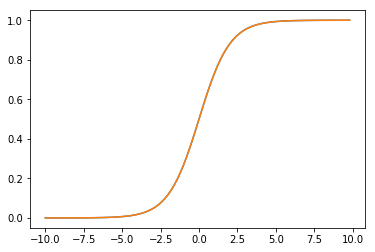

Hyperbolic Tangent(tanh)


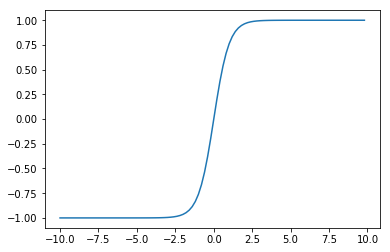

In [8]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math

def sigmoid(x):
    a = []
    for item in x:
        a.append(1/(1+math.exp(-item)))
    return a

def f2(x):
    a = []
    for item in x:
        a.append(math.tanh(item))
    return a
# tanh's parameters can be modified so that it is the same as the sigmoid funtion
def f3(x):
    a = []
    for item in x:
        a.append((math.tanh(0.5*item)+1)/2)
    return a

x = np.arange(-10., 10., 0.2)
y1 = sigmoid(x)
y2 = f2(x)
y3 = f3(x)

print("Sigmoid")
plt.plot(x,y1)
plt.plot(x,y3)
plt.show()

print("Hyperbolic Tangent(tanh)")
plt.plot(x,y2)
plt.show()

Both of these two functions compress their output to a specific range.  For the sigmoid function, this range is 0 to 1.  For the hyperbolic tangent function, this range is -1 to 1.

LSTM maintains an internal state and produces an output.  The following diagram shows an LSTM unit over three time slices: the current time slice (t), as well as the previous (t-1) and next (t+1) slice:

![LSTM Layers](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_10_lstm1.png "LSTM Layers")

The values $\hat{y}$ are the output from the unit, the values ($x$) are the input to the unit and the values $c$ are the context values.  Both the output and context values are always fed to the next time slice.  The context values allow 

![LSTM Layers](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_10_lstm2.png "Inside the LSTM")

LSTM is made up of three gates:

* Forget Gate (f_t) - Controls if/when the context is forgotten. (MC)
* Input Gate (i_t) - Controls if/when a value should be remembered by the context. (M+/MS)
* Output Gate (o_t) - Controls if/when the remembered value is allowed to pass from the unit. (RM)

Mathematically, the above diagram can be thought of as the following:

**These are vector values.**

First, calculate the forget gate value.  This gate determines if the short term memory is forgotten.  The value $b$ is a bias, just like the bias neurons we saw before.  Except LSTM has a bias for every gate: $b_t$, $b_i$, and $b_o$.

$$ f_t = S(W_f \cdot [\hat{y}_{t-1}, x_t] + b_f) $$

Next, calculate the input gate value. This gate's value determines what will be remembered.

$$ i_t = S(W_i \cdot [\hat{y}_{t-1},x_t] + b_i) $$

Calculate a candidate context value (a value that might be remembered).  This value is called $\tilde{c}$.

$$ \tilde{C}_t = \tanh(W_C \cdot [\hat{y}_{t-1},x_t]+b_C) $$

Determine the new context ($C_t$).  Do this by remembering the candidate context ($i_t$), depending on input gate.  Forget depending on the forget gate ($f_t$). 

$$ C_t = f_t \cdot C_{t-1}+i_t \cdot \tilde{C}_t $$

Calculate the output gate ($o_t$):

$$ o_t = S(W_o \cdot [\hat{y}_{t-1},x_t] + b_o ) $$

Calculate the actual output ($\hat{y}_t$):

$$ \hat{y}_t = o_t \cdot \tanh(C_t) $$


# Simple TensorFlow LSTM Example

The following code creates the LSTM network.  This is an example of RNN classification.  The following code trains on a data set (x) with a max sequence size of 6 (columns) and 6 training elements (rows)



# CIS 4115 Task 1
Run the 5 cells below which set up the data and LSTM network and test its performance
With the initial configuration, how many predictions were good/bad?
# CIS 4115 Task 2
Change the LSTM network or its training. Can you get the network to match all the output?
What was your best performance? What LSTM and training parameters did you change? 

In [21]:
#Import the libraries we need
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb
import numpy as np

In [22]:
# Define the input and output data

max_features = 4 # 0,1,2,3 (total of 4)
x = [
    [[0],[0],[0],[0],[0],[0]],
    [[0],[3],[3],[0],[1],[1]],
    [[0],[0],[0],[2],[2],[0]],
    [[2],[2],[0],[2],[2],[0]],
    [[3],[3],[0],[0],[0],[0]],
    [[0],[1],[1],[0],[1],[1]],
    [[2],[2],[1],[1],[0],[0]],
    [[0],[0],[0],[2],[2],[0]],
    [[0],[0],[0],[2],[2],[0]],
    [[0],[2],[1],[0],[3],[3]],
    [[1],[2],[2],[0],[0],[0]],
    [[1],[1],[3],[3],[0],[0]],
    [[0],[0],[0],[0],[1],[1]],
    [[0],[0],[0],[0],[0],[0]]
]
x = np.array(x,dtype=np.float32)
y = np.array([0,1,2,2,3,1,1,2,2,3,2,3,1,0],dtype=np.int32)

# Convert y2 to dummy variables
y2 = np.zeros((y.shape[0], max_features),dtype=np.float32)
y2[np.arange(y.shape[0]), y] = 1.0
print("Output data: ")
print(y2)

Output data: 
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]


In [23]:
print('Build model...')
model = Sequential()
# ortiginl version: model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, 1)))
model.add(LSTM(16, input_shape=(None, 1)))
model.add(Dense(4, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
# Try training for longer, say 200 epochs
model.fit(x,y2,epochs=20,verbose=1)


Build model...
Train...
Epoch 1/20
14/14 [==============================] - 1s 52ms/step - loss: 0.6855 - acc: 0.6607
Epoch 2/20
14/14 [==============================] - 0s 215us/step - loss: 0.6835 - acc: 0.6786
Epoch 3/20
14/14 [==============================] - 0s 286us/step - loss: 0.6815 - acc: 0.6786
Epoch 4/20
14/14 [==============================] - 0s 286us/step - loss: 0.6795 - acc: 0.6786
Epoch 5/20
14/14 [==============================] - 0s 287us/step - loss: 0.6776 - acc: 0.6786
Epoch 6/20
14/14 [==============================] - 0s 286us/step - loss: 0.6756 - acc: 0.6786
Epoch 7/20
14/14 [==============================] - 0s 358us/step - loss: 0.6737 - acc: 0.6786
Epoch 8/20
14/14 [==============================] - 0s 288us/step - loss: 0.6717 - acc: 0.6786
Epoch 9/20
14/14 [==============================] - 0s 286us/step - loss: 0.6698 - acc: 0.6786
Epoch 10/20
14/14 [==============================] - 0s 286us/step - loss: 0.6678 - acc: 0.6786
Epoch 11/20
14/14 [=======

### Test the results on the data
Each predicted class should match the expected class

In [20]:
pred = model.predict(x)
predict_classes = np.argmax(pred,axis=1)
print("Predicted classes: {}",predict_classes)
print("Expected  classes: {}",y)

Predicted classes: {} [2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Expected  classes: {} [0 1 2 2 3 1 1 2 2 3 2 3 1 0]


[[6.2244332e-01 2.5738895e-01 1.2541065e-01 4.0307257e-02]
 [1.1698235e-04 4.0348306e-01 2.0893718e-01 3.2902882e-01]
 [4.8385232e-04 3.9634973e-02 9.8175722e-01 1.9101255e-02]
 [3.9421753e-05 3.5816882e-02 9.2180520e-01 7.9864338e-02]
 [1.8928648e-04 3.5366648e-01 8.8102408e-02 5.2331853e-01]
 [1.9010677e-03 6.0372645e-01 1.6411865e-01 1.6255280e-01]
 [2.5888486e-04 4.0460154e-01 1.1431672e-01 3.8989079e-01]
 [4.8385232e-04 3.9634973e-02 9.8175722e-01 1.9101255e-02]
 [4.8385232e-04 3.9634973e-02 9.8175722e-01 1.9101255e-02]
 [2.3197950e-04 5.0188875e-01 5.5997051e-02 5.2684057e-01]
 [2.4940318e-04 3.8811779e-01 3.9856771e-01 1.4668143e-01]
 [2.2506135e-04 2.7598062e-01 1.9734301e-02 8.6442691e-01]
 [1.2532729e-01 4.1172579e-01 1.6837543e-01 7.2109111e-02]
 [6.2244332e-01 2.5738895e-01 1.2541065e-01 4.0307257e-02]]


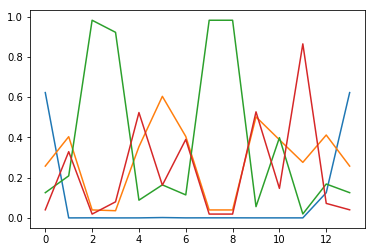

In [10]:
print (pred)
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(pred)

# CIS 4115 Task 3
A harder dataset is define below using longer sequenses. Modify the dataset, hardx, and the answers, hardy. The network should still recognize and remember the last "car" driven by. Try modifying the dataset in different ways and find a network that works well with the modified dataset.
Report both your final dataset and the network used.


In [35]:
# Define the input and output data

max_features = 4 # 0,1,2,3 (total of 4)
hardx = [
    [[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]],
    [[0],[3],[3],[0],[1],[1],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]],
    [[0],[0],[0],[2],[2],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]],
    [[2],[2],[0],[2],[2],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]],
    [[3],[3],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]],
    [[0],[1],[1],[0],[1],[1],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]],
    [[2],[2],[1],[1],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]],
    [[0],[0],[0],[2],[2],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]],
    [[0],[0],[0],[2],[2],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]],
    [[0],[2],[1],[0],[3],[3],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]],
    [[1],[2],[2],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]],
    [[1],[1],[3],[3],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]],
    [[0],[0],[0],[0],[1],[1],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]],
    [[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]]
]
hardx = np.array(hardx,dtype=np.float32)
hardy = np.array([0,1,2,2,3,1,1,2,2,3,2,3,1,0],dtype=np.int32)

# Convert y2 to dummy variables
hardy2 = np.zeros((hardy.shape[0], max_features),dtype=np.float32)
hardy2[np.arange(hardy.shape[0]), hardy] = 1.0
print("Output data: ")
print(hardy2)

Output data: 
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]


In [38]:
print('Build model...')
model2 = Sequential()
# ortiginl version: model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, 1)))
model2.add(LSTM(32, input_shape=(None, 1)))
model2.add(Dense(4, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
# Try training for longer, say 200 epochs
model2.fit(hardx,hardy2,epochs=200,verbose=1)

Build model...
Train...
Epoch 1/200
14/14 [==============================] - 1s 70ms/step - loss: 0.6928 - acc: 0.5893
Epoch 2/200
14/14 [==============================] - 0s 427us/step - loss: 0.6913 - acc: 0.7143
Epoch 3/200
14/14 [==============================] - 0s 499us/step - loss: 0.6899 - acc: 0.7321
Epoch 4/200
14/14 [==============================] - 0s 499us/step - loss: 0.6884 - acc: 0.7500
Epoch 5/200
14/14 [==============================] - 0s 573us/step - loss: 0.6869 - acc: 0.7500
Epoch 6/200
14/14 [==============================] - 0s 501us/step - loss: 0.6854 - acc: 0.7500
Epoch 7/200
14/14 [==============================] - 0s 573us/step - loss: 0.6838 - acc: 0.7500
Epoch 8/200
14/14 [==============================] - 0s 501us/step - loss: 0.6822 - acc: 0.7500
Epoch 9/200
14/14 [==============================] - 0s 430us/step - loss: 0.6805 - acc: 0.7500
Epoch 10/200
14/14 [==============================] - 0s 501us/step - loss: 0.6787 - acc: 0.7500
Epoch 11/200
14/

Epoch 86/200
14/14 [==============================] - 0s 573us/step - loss: 0.4822 - acc: 0.7500
Epoch 87/200
14/14 [==============================] - 0s 501us/step - loss: 0.4798 - acc: 0.7500
Epoch 88/200
14/14 [==============================] - 0s 501us/step - loss: 0.4774 - acc: 0.7500
Epoch 89/200
14/14 [==============================] - 0s 430us/step - loss: 0.4750 - acc: 0.7500
Epoch 90/200
14/14 [==============================] - 0s 501us/step - loss: 0.4728 - acc: 0.7500
Epoch 91/200
14/14 [==============================] - 0s 644us/step - loss: 0.4704 - acc: 0.7143
Epoch 92/200
14/14 [==============================] - 0s 501us/step - loss: 0.4679 - acc: 0.7143
Epoch 93/200
14/14 [==============================] - 0s 501us/step - loss: 0.4654 - acc: 0.7143
Epoch 94/200
14/14 [==============================] - 0s 573us/step - loss: 0.4629 - acc: 0.7143
Epoch 95/200
14/14 [==============================] - 0s 501us/step - loss: 0.4604 - acc: 0.7143
Epoch 96/200
14/14 [==========

Epoch 170/200
14/14 [==============================] - 0s 501us/step - loss: 0.2445 - acc: 0.9107
Epoch 171/200
14/14 [==============================] - 0s 430us/step - loss: 0.2430 - acc: 0.9107
Epoch 172/200
14/14 [==============================] - 0s 430us/step - loss: 0.2415 - acc: 0.9107
Epoch 173/200
14/14 [==============================] - 0s 501us/step - loss: 0.2400 - acc: 0.9107
Epoch 174/200
14/14 [==============================] - 0s 572us/step - loss: 0.2386 - acc: 0.9107
Epoch 175/200
14/14 [==============================] - 0s 501us/step - loss: 0.2372 - acc: 0.9107
Epoch 176/200
14/14 [==============================] - 0s 501us/step - loss: 0.2358 - acc: 0.9107
Epoch 177/200
14/14 [==============================] - 0s 501us/step - loss: 0.2344 - acc: 0.9107
Epoch 178/200
14/14 [==============================] - 0s 573us/step - loss: 0.2330 - acc: 0.9107
Epoch 179/200
14/14 [==============================] - 0s 501us/step - loss: 0.2316 - acc: 0.9107
Epoch 180/200
14/14 

In [39]:
pred = model2.predict(hardx)
predict_classes = np.argmax(pred,axis=1)
print("Predicted classes: {}",predict_classes)
print("Expected  classes: {}",hardy)

Predicted classes: {} [0 3 2 3 3 1 1 2 2 3 2 3 1 0]
Expected  classes: {} [0 1 2 2 3 1 1 2 2 3 2 3 1 0]


# CIS 4115 Task 4
Set up some unique testing data that the system has not seen. You can use the same format as above, just with different variable names. Run this new testing data through the predict() method and see how it performs 

In [ ]:
pred = model2.predict(YOUR_DATA_X)
predict_classes = np.argmax(pred,axis=1)
print("Predicted classes: {}",predict_classes)
print("Expected  classes: {}",YOUR_DATA_Y)


# Sun Spots Example

An example of RNN regression to predict sunspots.  The data files needed for this example can be found at the following location.

* [Sunspot Data Files](http://www.sidc.be/silso/datafiles#total)
* [Download Daily Sunspots](http://www.sidc.be/silso/INFO/sndtotcsv.php) - 1/1/1818 to now.

The following code is used to load the sunspot file:


# CIS 4115 Task 5
Try to download the sunspot data and run the sample below.
Report any problems you have or the results.

In [41]:
import pandas as pd
import os

# Replacce the following path with your own file. It can be downloaded from:
# http://www.sidc.be/silso/INFO/sndtotcsv.php

# save the data file in the same folder as this Jupyter notebook
filename = "SN_d_tot_V2.0.csv"    
names = ['year', 'month', 'day', 'dec_year', 'sn_value' , 'sn_error', 'obs_num']
df = pd.read_csv(filename,sep=';',header=None,names=names,na_values=['-1'], index_col=False)

print("Starting file:")
print(df[0:10])

print("Ending file:")
print(df[-10:])

FileNotFoundError: File b'SN_d_tot_V2.0.csv' does not exist

As you can see, there is quite a bit of missing data near the end of the file.  We would like to find the starting index where the missing data no longer occurs.  This is somewhat sloppy, it would be better to find a use for the data between missing values.  However, the point of this example is show how to use LSTM with a somewhat simple time-series.

In [42]:
start_id = max(df[df['obs_num'] == 0].index.tolist())+1  # Find the last zero and move one beyond
print(start_id)
df = df[start_id:] # Trim the rows that have missing observations

KeyError: 'obs_num'

In [ ]:
df_train = df[df['year']<2000]
df_test = df[df['year']>=2000]

spots_train = df_train['sn_value'].tolist()
spots_test = df_test['sn_value'].tolist()

print("Training set has {} observations.".format(len(spots_train)))
print("Test set has {} observations.".format(len(spots_test)))

In [ ]:
import numpy as np


    
SEQUENCE_SIZE = 10
x_train,y_train = to_sequences(SEQUENCE_SIZE,spots_train)
x_test,y_test = to_sequences(SEQUENCE_SIZE,spots_test)

print("Shape of training set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))

In [ ]:
x_train

In [ ]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb
from keras.callbacks import EarlyStopping
import numpy as np

print('Build model...')
model = Sequential()
model.add(LSTM(64, dropout=0.0, recurrent_dropout=0.0,input_shape=(None, 1)))
model.add(Dense(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
print('Train...')

model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)

In [ ]:
from sklearn import metrics

pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))